# Time dependent ITER simulation

In [12]:
using Plots;
gr();
@time using FUSE
FUSE.logging(Logging.Info; actors=Logging.Info);
FUSE.ProgressMeter.ijulia_behavior(:clear);

  0.000106 seconds (151 allocations: 13.984 KiB)


In [13]:
ini, act = FUSE.case_parameters(:ITER; init_from=:scalars, ne_setting=:greenwald_fraction_ped);
#act.ActorEquilibrium.model = :CHEASE
function my_time_dependence(ini)
    ini.time.pulse_shedule_time_basis = range(0.0,500, 100);
    ini.equilibrium.ip = t -> ramp(t / 100.0) * 14E6 + ramp((t - 200) / 100.0) * 1E6
    ini.nb_unit[1].power_launched = t -> 16.7e6 + ramp((t - 200) / 100.0) * 16.7e6
    ini.ec_launcher[1].power_launched = t -> 10e6 + ramp((t - 200) / 100.0) * 10e6
    ini.ic_antenna[1].power_launched = t -> 12e6 + ramp((t - 200) / 100.0) * 12e6
    # ini.ec_launcher[1].rho_0 = 0.5
    # ini.ec_launcher[1].width = 0.05
    ini.core_profiles.T_ratio = 1.0
    act.ActorEPED.ped_factor = 1.0
    return ini
end
my_time_dependence(ini);
ini.time.simulation_start = 400.0;

In [14]:
# using Interact
# @manipulate for time0 in ini.time.pulse_shedule_time_basis
#     plot(ini; color=:red)
#     plot!(ini; time0, color=:blue)
# end

[ Info: Equilibrium
[ Info:  TEQUILA
[ Info: HCD
[ Info:  SimpleEC
[ Info:  SimpleIC
[ Info:  SimpleLH
[ Info:  SimpleNB
[ Info:  SimplePellet
[ Info: Current
[ Info:  SteadyStateCurrent
[ Info: CXbuild


 21.492586 seconds (91.41 M allocations: 12.230 GiB, 6.86% gc time, 58.52% compilation time: 99% of which was recompilation)


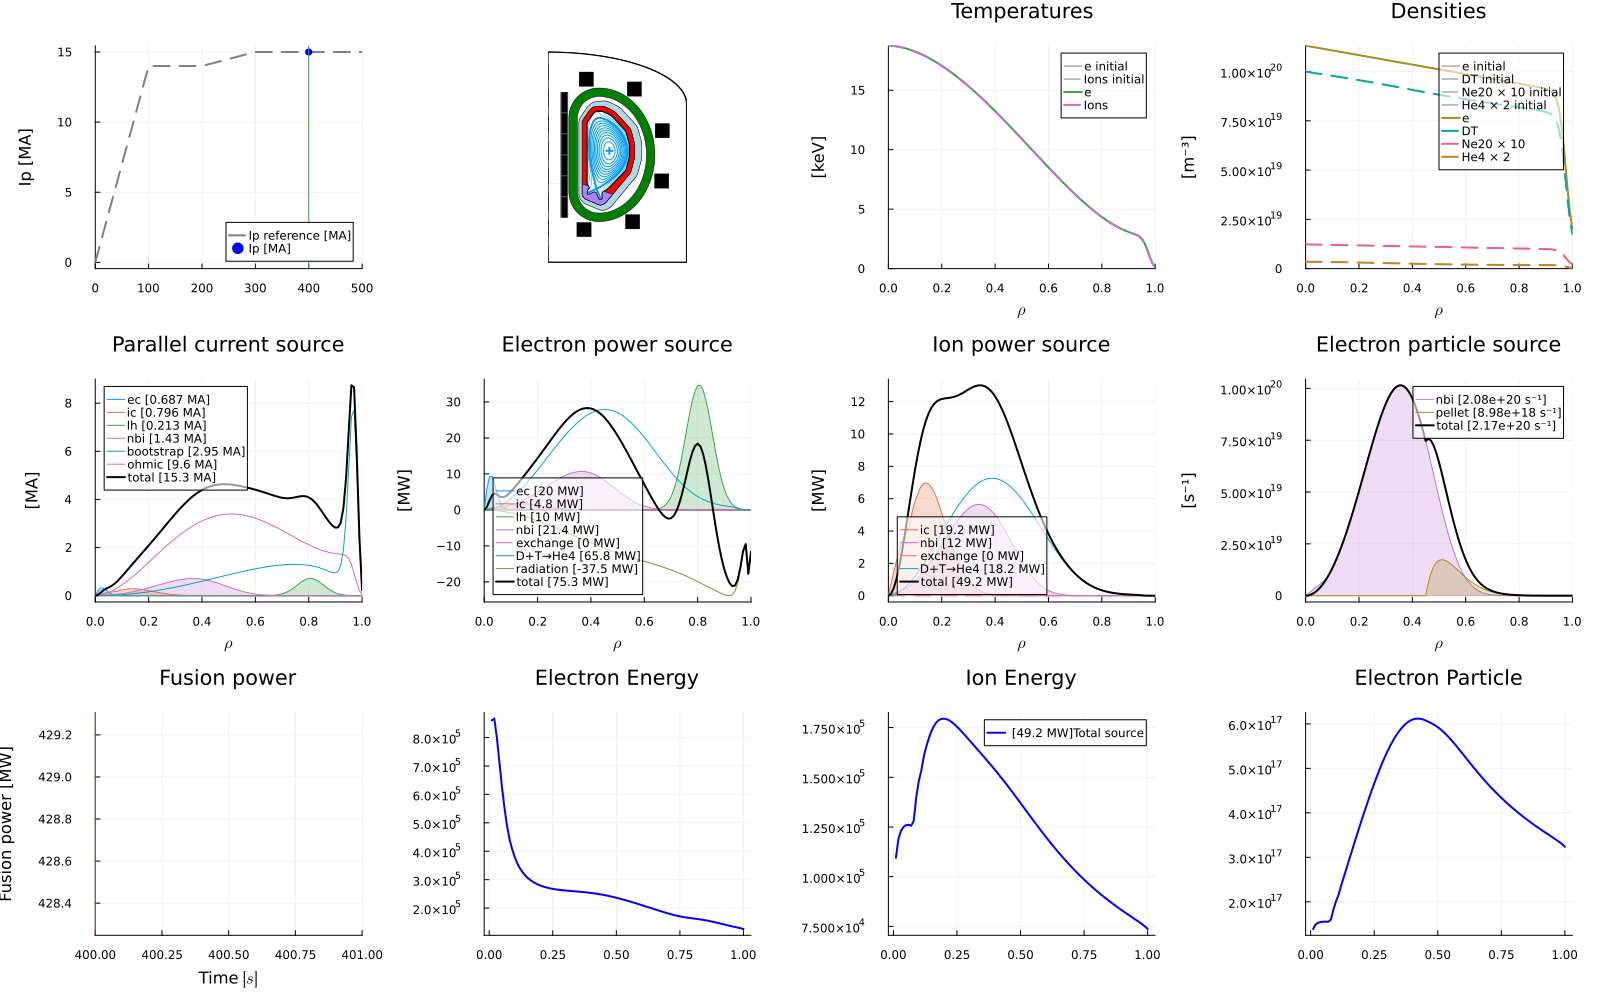

In [15]:
chk = FUSE.Checkpoint();

dd = IMAS.dd()
@time dd = FUSE.init(dd, ini, act);

chk[:init] = dd, ini, act;

FUSE.plot_plasma_overview(dd, dd.global_time; min_power=1E6, aggregate_radiation=true)

In [16]:
# using Interact
# @manipulate for time0 in dd.pulse_schedule.flux_control.time
#     plot(dd.pulse_schedule; time0)
# end

In [17]:
dd, ini, act = chk[:init]

act.ActorStationaryPlasma.convergence_error=1E-3

act.ActorPedestal.model = :WPED
act.ActorWPED.ped_to_core_fraction = 0.3

act.ActorCoreTransport.model = :FluxMatcher
act.ActorFluxMatcher.rho_transport=0.25:0.05:0.85
act.ActorFluxMatcher.max_iterations = 500
act.ActorFluxMatcher.optimizer_algorithm=:anderson

actor=FUSE.ActorStationaryPlasma(dd, act; do_plot=false, verbose=true)

FUSE.plot_plasma_overview(dd, dd.global_time; min_power=1E6, aggregate_radiation=true)

[ Info: StationaryPlasma


LoadError: Bad expression core_profiles.profiles_1d[0].grid.volume
type Missing has no field equilibrium
Stacktrace:
  [1] getproperty(x::Missing, f::Symbol)
    @ Base ./Base.jl:37
  [2] (::IMAS.var"#637#639")(rho_tor_norm::Vector{Float64}; dd::Missing, profiles_1d::IMASDD.core_profiles__profiles_1d{Float64}, ::@Kwargs{core_profiles::Missing, grid::IMASDD.core_profiles__profiles_1d___grid{Float64}, profiles_1d_index::Missing})
    @ IMAS ~/.julia/dev/IMAS/src/expressions/onetime.jl:32
  [3] macro expansion
    @ ~/.julia/dev/IMASDD/src/expressions.jl:110 [inlined]
  [4] macro expansion
    @ ~/.julia/packages/TimerOutputs/Lw5SP/src/TimerOutput.jl:237 [inlined]
  [5] exec_expression_with_ancestor_args(ids::IMASDD.IDS, field::Symbol, func::Function)
    @ IMASDD ~/.julia/dev/IMASDD/src/expressions.jl:103
  [6] _getproperty(ids::IMASDD.IDS, field::Symbol)
    @ IMASDD ~/.julia/dev/IMASDD/src/data.jl:355
  [7] getproperty
    @ ~/.julia/dev/IMASDD/src/data.jl:212 [inlined]
  [8] core_and_edge_energy(cp1d::IMASDD.core_profiles__profiles_1d{Float64}, rho_ped::Float64)
    @ FUSE ~/.julia/dev/FUSE/src/actors/pedestal/WPED_actor.jl:152
  [9] cost_WPED_ztarget_pedratio!(cp1d::IMASDD.core_profiles__profiles_1d{Float64}, value_bound::Float64, ped_to_core_fraction::Float64, rho_ped::Float64, Ti_over_Te::Float64)
    @ FUSE ~/.julia/dev/FUSE/src/actors/pedestal/WPED_actor.jl:120
 [10] cost_WPED_ztarget_pedratio(cp1d::IMASDD.core_profiles__profiles_1d{Float64}, value_bound::Float64, ped_to_core_fraction::Float64, rho_ped::Float64, Ti_over_Te::Float64)
    @ FUSE ~/.julia/dev/FUSE/src/actors/pedestal/WPED_actor.jl:102
 [11] #1090
    @ ~/.julia/dev/FUSE/src/actors/pedestal/WPED_actor.jl:75 [inlined]
 [12] optimize(f::FUSE.var"#1090#1091"{Float64, IMASDD.core_profiles__profiles_1d{Float64}, FUSE.FUSEparameters__ActorWPED{Float64}}, x_lower::Float64, x_upper::Float64, mo::Optim.GoldenSection; rel_tol::Float64, abs_tol::Float64, iterations::Int64, store_trace::Bool, show_trace::Bool, show_warnings::Bool, callback::Nothing, show_every::Int64, extended_trace::Bool, nargs::@Kwargs{})
    @ Optim ~/.julia/packages/Optim/ZhuZN/src/univariate/solvers/golden_section.jl:45
 [13] _step(actor::FUSE.ActorWPED{Float64, Float64})
    @ FUSE ~/.julia/dev/FUSE/src/actors/pedestal/WPED_actor.jl:74
 [14] step(::FUSE.ActorWPED{Float64, Float64}; kw::@Kwargs{})
    @ FUSE ~/.julia/dev/FUSE/src/actors.jl:105
 [15] step
    @ ~/.julia/dev/FUSE/src/actors.jl:102 [inlined]
 [16] _step(actor::FUSE.ActorPedestal{Float64, Float64})
    @ FUSE ~/.julia/dev/FUSE/src/actors/pedestal/pedestal_actor.jl:88
 [17] step(::FUSE.ActorPedestal{Float64, Float64}; kw::@Kwargs{})
    @ FUSE ~/.julia/dev/FUSE/src/actors.jl:105
 [18] step
    @ ~/.julia/dev/FUSE/src/actors.jl:102 [inlined]
 [19] _step(actor::FUSE.ActorStationaryPlasma{Float64, Float64})
    @ FUSE ~/.julia/dev/FUSE/src/actors/compound/stationary_plasma_actor.jl:121
 [20] macro expansion
    @ ~/.julia/dev/FUSE/src/actors.jl:114 [inlined]
 [21] macro expansion
    @ ~/.julia/packages/TimerOutputs/Lw5SP/src/TimerOutput.jl:237 [inlined]
 [22] step(::FUSE.ActorStationaryPlasma{Float64, Float64}; kw::@Kwargs{})
    @ FUSE ~/.julia/dev/FUSE/src/actors.jl:109
 [23] step
    @ ~/.julia/dev/FUSE/src/actors.jl:102 [inlined]
 [24] #ActorStationaryPlasma#1375
    @ ~/.julia/dev/FUSE/src/actors/compound/stationary_plasma_actor.jl:42 [inlined]
 [25] top-level scope
    @ In[17]:13
 [26] eval
    @ ./boot.jl:385 [inlined]
 [27] include_string(mapexpr::typeof(REPL.softscope), mod::Module, code::String, filename::String)
    @ Base ./loading.jl:2076
 [28] softscope_include_string(m::Module, code::String, filename::String)
    @ SoftGlobalScope ~/.julia/packages/SoftGlobalScope/u4UzH/src/SoftGlobalScope.jl:65
 [29] execute_request(socket::ZMQ.Socket, msg::IJulia.Msg)
    @ IJulia ~/.julia/packages/IJulia/Vo51o/src/execute_request.jl:67
 [30] #invokelatest#2
    @ ./essentials.jl:892 [inlined]
 [31] invokelatest
    @ ./essentials.jl:889 [inlined]
 [32] eventloop(socket::ZMQ.Socket)
    @ IJulia ~/.julia/packages/IJulia/Vo51o/src/eventloop.jl:8
 [33] (::IJulia.var"#15#18")()
    @ IJulia ~/.julia/packages/IJulia/Vo51o/src/eventloop.jl:38

[ Info: Equilibrium
[ Info:  TEQUILA
[ Info: HCD
[ Info:  SimpleEC
[ Info:  SimpleIC
[ Info:  SimpleLH
[ Info:  SimpleNB
[ Info:  SimplePellet
[ Info: Current
[ Info:  SteadyStateCurrent


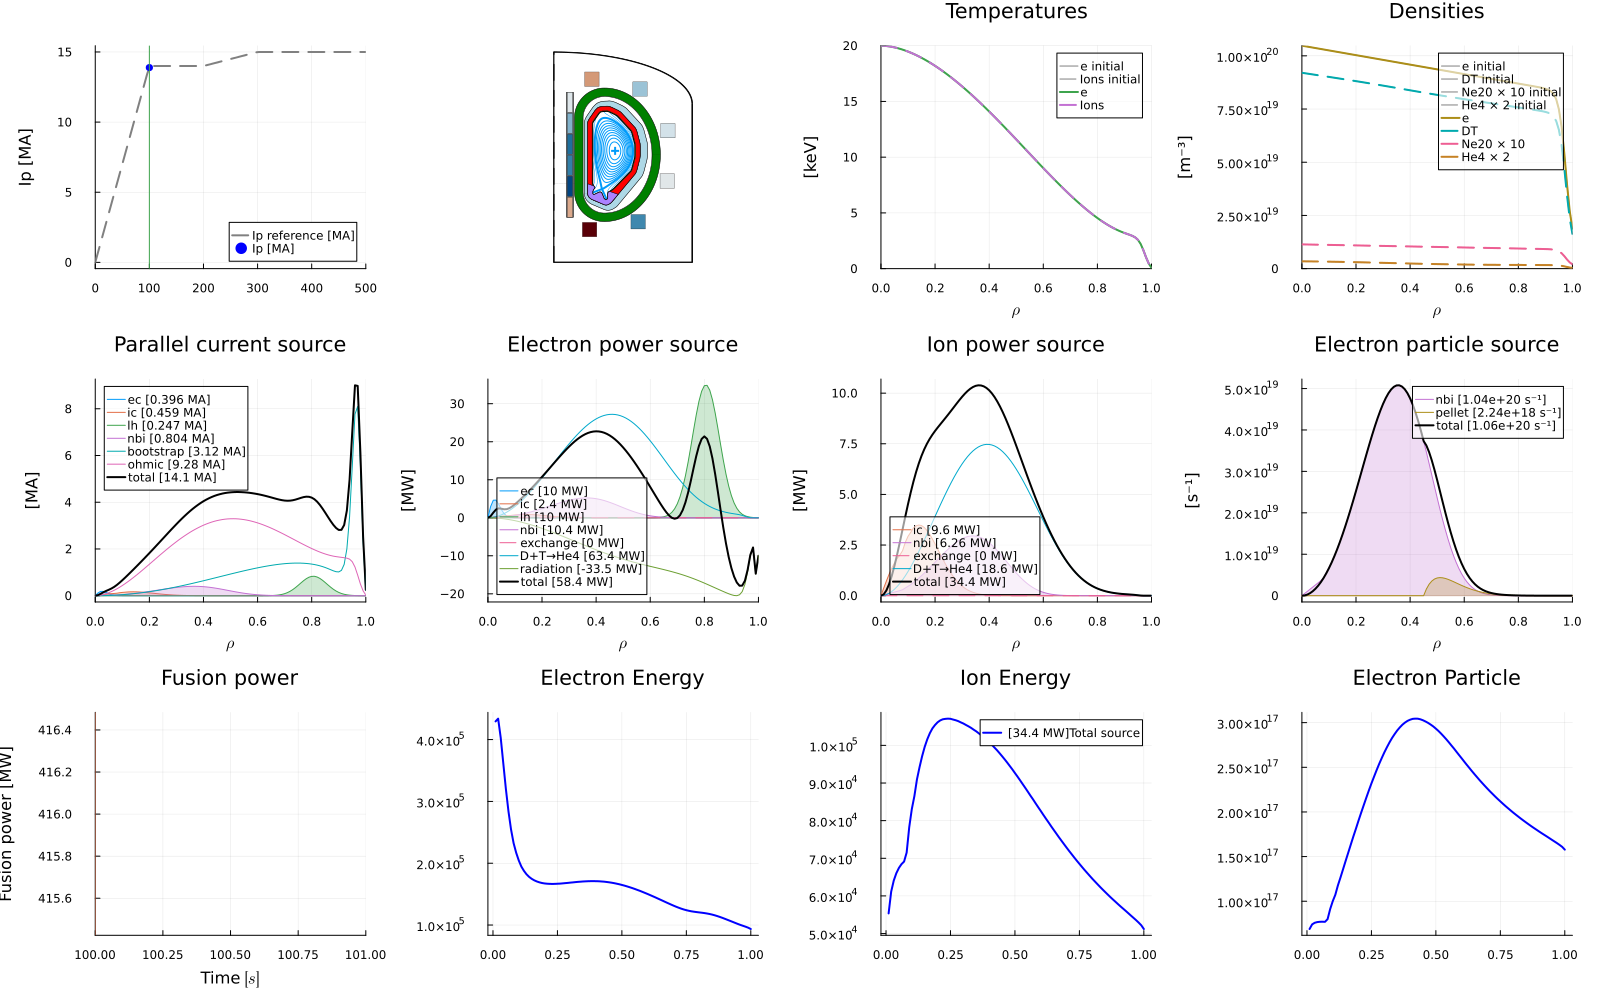

In [382]:
dd,ini,act = chk[:init]

#ini, act = FUSE.case_parameters(:ITER; init_from=:scalars, ne_setting=:greenwald_fraction_ped);
#my_time_dependence(ini);
ini.time.simulation_start = 100.0

#empty!(dd.pulse_schedule)
FUSE.init(dd, ini, act; initialize_hardware=false);

chk[:tinit] = (dd, ini, act);

FUSE.plot_plasma_overview(dd, dd.global_time; min_power=1E6, aggregate_radiation=true)

In [ ]:
dd,ini,act = chk[:tinit]

#act.ActorStationaryPlasma.convergence_error=1E-3
#act.ActorStationaryPlasma.max_iter=10

act.ActorPedestal.model=:EPED

act.ActorCoreTransport.model = :FluxMatcher
act.ActorFluxMatcher.rho_transport=0.25:0.05:0.85
act.ActorFluxMatcher.max_iterations = 300
act.ActorFluxMatcher.optimizer_algorithm=:anderson

FUSE.ActorStationaryPlasma(dd, act; do_plot=false, verbose=true)

chk[:stationary] = (dd, ini, act);

FUSE.plot_plasma_overview(dd, dd.global_time; min_power=1E6, aggregate_radiation=true)

In [512]:
FUSE.ProgressMeter.ijulia_behavior(:clear)
IMAS.IMASDD.TimerOutputs.reset_timer!(IMAS.IMASDD.expressions_timer)

dd, ini, act = chk[:stationary]

#act.ActorFluxMatcher.max_iterations = 100
#act.ActorFluxMatcher.optimizer_algorithm = :anderson

act.ActorDynamicPlasma.verbose = true
n = 1
act.ActorDynamicPlasma.Nt = Int(60/n)
act.ActorDynamicPlasma.Δt = 300.0/n

# should profile with all evolutions set to false and see where time is lost

act.ActorDynamicPlasma.evolve_current = false
act.ActorDynamicPlasma.evolve_equilibrium = false
act.ActorDynamicPlasma.evolve_pedestal = false
act.ActorDynamicPlasma.evolve_transport = false
act.ActorDynamicPlasma.evolve_hcd = false
act.ActorDynamicPlasma.evolve_pf_active = false
act.ActorDynamicPlasma.ip_controller = false

FUSE.ActorDynamicPlasma(dd, act);

chk[:time_dep] = dd, ini, act;

1
2
3
4
5
6
7
8
9
10


[ Info: DynamicPlasma


LoadError: InterruptException:

In [460]:
lw = 2
using Interact

a = @animate for (k, time0) in collect(enumerate(dd.core_sources.time))[1:end]
    @show time0
    #@manipulate for k in eachindex(dd.core_sources.time)
    time0 = dd.core_sources.time[k]
    FUSE.plot_plasma_overview(dd, time0; min_power=1E6, aggregate_radiation=true)
    #    savefig(joinpath("/Users/meneghini/Library/CloudStorage/Dropbox/tex/figures/FUSE/gif", "frame_$(lpad(k-1, 4, '0')).png"));
end

time0 = 100.0
time0 = 102.5
time0 = 105.0
time0 = 107.5
time0 = 110.0


Animation("/var/folders/8x/f0x8khz50495tv7skxdjqvhc0000gr/T/jl_9Kl74O", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png"])

In [ ]:
g = gif(a, "ITER_time_dep_noδt_nepedGW.gif", fps=12)
display(g)

In [483]:
show(IOContext(stdout, :limit=>true, :displaysize=>(1000,1000)), IMAS.IMASDD.expressions_timer)

 ────────────────────────────────────────────────────────────────────────────────────────────────────
                                                            Time                    Allocations      
                                                   ───────────────────────   ────────────────────────
                 Tot / % measured:                      25.7s /   0.0%           5.41GiB /   0.0%    

 Section                                   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────────────────────────
 core_profiles.profiles_1d[1].j_tor             1    695μs   17.9%   695μs    132KiB    7.4%   132KiB
   core_profiles.profiles_1d[1].j_total         1   68.6μs    1.8%  68.6μs   3.56KiB    0.2%  3.56KiB
 core_profiles.profiles_1d[11].j_tor            1    278μs    7.2%   278μs    134KiB    7.6%   134KiB
   core_profiles.profiles_1d[11].j_total        1   17.5μs    0.5%  17.5μs   3.56

In [502]:
dd.core_sources.source[1]

1
├─ identifier
│  ├─ index ➡ 3
│  └─ name ➡ "ec"
└─ profiles_1d
   └─ 1
      ├─ current_parallel_inside ➡ 101-element Vector{Float64} [A]
      ├─ electrons
      │  ├─ energy ➡ 101-element Vector{Float64} [W.m^-3]
      │  ├─ particles ➡ 101-element Vector{Float64} [m^-3.s^-1] (all 0.0)
      │  ├─ particles_inside ➡ 101-element Vector{Float64} [s^-1] (all 0.0)
      │  └─ power_inside ➡ 101-element Vector{Float64} [W]
      ├─ grid
      │  ├─ area ➡ 101-element Vector{Float64} [m^2]
      │  ├─ psi ➡ Function [Wb]
      │  ├─ psi_norm ➡ Function
      │  ├─ rho_tor_norm ➡ 101-element Vector{Float64}
      │  ├─ surface ➡ Function [m^2]
      │  └─ volume ➡ 101-element Vector{Float64} [m^3]
      ├─ j_parallel ➡ 101-element Vector{Float64} [A.m^-2]
      ├─ momentum_tor ➡ 101-element Vector{Float64} [kg.m^-1.s^-2] (all 0.0)
      ├─ time ➡ 100 [s]
      ├─ torque_tor_inside ➡ 101-element Vector{Float64} [kg.m^2.s^-2] (all 0.0)
      ├─ total_ion_energy ➡ 101-element Vector{Float64}

In [ ]:
dd.core_profiles.profiles_1d[end]

In [436]:
dd.core_profiles.profiles_1d[].ion

ion
├─ 1
│  ├─ density ➡ Function [m^-3]
│  ├─ density_fast ➡ 101-element Vector{Float64} [m^-3]
│  ├─ density_thermal ➡ 101-element Vector{Float64} [m^-3]
│  ├─ element
│  │  └─ 1
│  │     ├─ a ➡ 2.515 [Atomic Mass Unit]
│  │     └─ z_n ➡ 1 [Elementary Charge Unit]
│  ├─ label ➡ "DT"
│  ├─ pressure_fast_parallel ➡ 101-element Vector{Float64} [Pa]
│  ├─ pressure_fast_perpendicular ➡ 101-element Vector{Float64} [Pa]
│  ├─ pressure_thermal ➡ Function [Pa]
│  ├─ temperature ➡ 101-element Vector{Float64} [eV]
│  └─ z_ion ➡ Function [Elementary Charge Unit]
├─ 2
│  ├─ density ➡ Function [m^-3]
│  ├─ density_fast ➡ 101-element Vector{Float64} [m^-3] (all 0.0)
│  ├─ density_thermal ➡ 101-element Vector{Float64} [m^-3]
│  ├─ element
│  │  └─ 1
│  │     ├─ a ➡ 20.1797 [Atomic Mass Unit]
│  │     └─ z_n ➡ 10 [Elementary Charge Unit]
│  ├─ label ➡ "Ne20"
│  ├─ pressure_fast_parallel ➡ 101-element Vector{Float64} [Pa] (all 0.0)
│  ├─ pressure_fast_perpendicular ➡ 101-element Vector{Float64} [Pa] (